In [1]:
import warnings
warnings.filterwarnings("ignore")

___
# Research Strategies that involve CME Weekly, Monday and Wednesday expirations

In [2]:

import zipfile
import glob
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from argparse import RawDescriptionHelpFormatter
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display

import peakutils
from peakutils.plot import plot as pplot
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


from scipy.signal import argrelextrema


import datetime
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import mibian
import py_vollib
import importlib
from py_vollib import black
from py_vollib.black import implied_volatility
import ipdb
import traceback
import pandas_datareader.data as pdr
from dashapp import dashapp2 as dashapp
import dash_html_components as html
import dash_core_components as dcc
from itertools import accumulate 
import pathlib
import shutil
import urllib.request as request
from contextlib import closing
import zipfile
import re

importlib.reload(dashapp)

<module 'dashapp.dashapp2' from '/Users/bperlman1/Documents/billybyte/pyliverisk/dashapp/dashapp/dashapp2.py'>

In [3]:
from pandas.tseries.holiday import USFederalHolidayCalendar
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
dt_holidays = [pd.to_datetime(t) for t in USFederalHolidayCalendar().holidays()]


2020-06-20 14:23:28,952 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [4]:
d20200703 = datetime.datetime(2020,7,3)
[(d.year,d.month,d.day) for d in dt_holidays]
d20200703 in dt_holidays

True

### important global variables

In [5]:

DEBUG_IT=False
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'


#### get all contracts in the options database

In [6]:
pga = db_info.get_db_info()
print(f"futtab max date: {pga.get_sql(f'select max(settle_date) from {futtab}')}")
print(f"opttab max date: {pga.get_sql(f'select max(settle_date) from {opttab}')}")


  sec_db
futtab max date:         max
0  20200618
opttab max date:         max
0  20200618


In [7]:
def _create_batch_indices(l,n):
    ii = list(range(l))
    num = n
    # list of length in which we have to split 
    length_to_split = list(np.repeat(num,len(ii)/num )) + [len(ii)%num]
    print(length_to_split)

    # Using islice 
    r = [ii[x - y: x] for x, y in zip( 
              accumulate(length_to_split), length_to_split)] 
    return r
_create_batch_indices(11,3)

[3, 3, 3, 2]


[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10]]

In [8]:
def str_to_date(d,sep='-'):
    try:
        dt = datetime.datetime.strptime(str(d)[:10],f'%Y{sep}%m{sep}%d')
    except:
        return None
    return dt

def dt_to_yyyymmdd(d):
    return int(d.year)*100*100 + int(d.month)*100 + int(d.day)

def str_to_yyyymmdd(d,sep='-'):
    try:
        dt = datetime.datetime.strptime(str(d)[:10],f'%Y{sep}%m{sep}%d')
    except:
        return None
    s = '%04d%02d%02d' %(dt.year,dt.month,dt.day)
    return int(s)

def yyyymmdd_to_dt(yyyymmdd):
    y = int(str(yyyymmdd)[0:4])
    m = int(str(yyyymmdd)[4:6])
    d = int(str(yyyymmdd)[6:8])
    return datetime.datetime(y,m,d)

def yyyymmdd_add_days(yyyymmdd,days=1):
    d = yyyymmdd_to_dt(yyyymmdd) + datetime.timedelta(days)
    return dt_to_yyyymmdd(d)

def get_local_peaks_and_valleys(df_in,n,col='close'):
    '''
    :param df - Input DataFrame
    :param n - number of data points that surround peak and valley
    :param col - the data column to observe
    '''
    df = df_in.copy()
    # Find local peaks
    df['valley'] = df.iloc[argrelextrema(df[col].values, np.less_equal, order=n)[0]][col]
    df['peak'] = df.iloc[argrelextrema(df[col].values, np.greater_equal, order=n)[0]][col]
    return df
 
def get_draw_downs(df_in,close='close'):
    df = df_in.copy()
    df['peak'] = df[close].expanding(min_periods=1).max()
    df['drawdown'] = df.peak-df[close]
    return df.drawdown
    

In [9]:
def get_spread(contract_front,contract_back):
    sql = f"""
    with 
    f1 as (
        select *
        from {futtab} 
        where symbol in ('{contract_front}','{contract_back}')
    )
    select * from f1 
    """
    df = pga.get_sql(sql)
    df1 = df[df.symbol==contract_front].copy()
    df2 = df[df.symbol==contract_back].copy()
    df1['front'] = df1.close
    df2['back'] = df2.close
    df_both = df1[['settle_date','front']].merge(
        df2[['settle_date','back']],on='settle_date',how='inner')
    df_both['spread'] = df_both.front - df_both.back
    return df_both

MONTH_CODES = 'FGHJKMNQUVXZ'
DICT_MONTH_CODE = {MONTH_CODES[i]:i+1 for i in range(len(MONTH_CODES))}


def get_nth_weekday(year,month,target_weekday,nth_occurrence):
    '''
    weekday is the term that assigns numbers from 0 to 6 to the days of the weeks.
    weekday 0 = monday
    '''
    # get dayofweeks of year,month,1
    weekday_01 = datetime.datetime(year,month,1).weekday()
    if weekday_01 <= target_weekday:
        day_of_month_of_first_occurence = target_weekday - weekday_01
        day_of_month_of_nth_occurence = day_of_month_of_first_occurence + 1 + (nth_occurrence - 1) * 7
    else:
        day_of_month_of_nth_occurence = target_weekday - weekday_01 + 1 + (nth_occurrence) * 7 
    return datetime.datetime(year,month,day_of_month_of_nth_occurence)




def get_CL_expiry(symbol):
    '''
    Futures expiry:
    Trading terminates 3 business day prior to the 25th calendar day 
    of the month prior to the contract month. If the 25th calendar day 
    is not a business day, trading terminates 4 business days prior to 
    the 25th calendar day of the month prior to the contract month.
    '''
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    month = month -1
    if month<1:
        month = 12
        year = year - 1
    day25 = datetime.datetime(year,month,25)
    if (day25.weekday()>4) or (day25 in dt_holidays):
        return day25 - 4*bday_us
    return day25 - 3*bday_us

def get_HO_expiry(symbol):
    '''Trading terminates on the last business day of the month prior to the contract month'''
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    last_bday_of_month = datetime.datetime(year,month,1) - 1*bday_us
    return last_bday_of_month

def get_RB_expiry(symbol):
    '''Trading terminates on the last business day of the month prior to the contract month'''
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    last_bday_of_month = datetime.datetime(year,month,1) - 1*bday_us
    return last_bday_of_month



def get_ES_expiry(symbol):
    '''
    3rd friday of month of symbol
    '''
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    return get_nth_weekday(year,month,4,3)

def get_CB_expiry(symbol):
    '''
    This is the spec for the CME Brent, but it matches ICE.
    Trading terminates the 4th last London business day of 
    the month, 2 months prior to the contract month 
    except for the February contract month which 
    terminates the 5th last London business day of the 
    month, 2 months prior to the contract month.  
    '''
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    month = month - 1
    if month<1:
        month = 12 + month
        year = year - 1
    days_to_subtract = 4
    if monthcode_yy[0] =='G':
        days_to_subtract = 5
    elif monthcode_yy[0] == 'F':
        days_to_subtract = 3
#     elif monthcode_yy == 'N22':
#         days_to_subtract = 7
    return datetime.datetime(year,month,1,0,0) - days_to_subtract * bday_uk

def get_NG_expiry(symbol):
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    return datetime.datetime(year,month,1) - 3*bday_us

DICT_PRODUCT = {
    'ES':get_ES_expiry,
    'CL':get_CL_expiry,
    'HO':get_HO_expiry,
    'RB':get_RB_expiry,
    'NG':get_NG_expiry,
    'CB':get_CB_expiry,
}

    
def get_expiry(symbol):
    product = symbol[:2]
    if product not in DICT_PRODUCT:
        return None
    f = DICT_PRODUCT[product]
    return f(symbol)


#### Test expiry logic

In [10]:
df_cl_calendar = pd.read_csv(f"./CL_calendar.csv")
display.display([d for d in df_cl_calendar['Last Trade'] if int(d[0:4])==2020])
[get_expiry(f'CL{m}20') for m in 'FGHJKMNQUVXZ'] + [get_expiry('CLF21')]

['2020-06-22',
 '2020-07-21',
 '2020-08-20',
 '2020-09-22',
 '2020-10-20',
 '2020-11-20',
 '2020-12-21']

[Timestamp('2019-12-19 00:00:00'),
 Timestamp('2020-01-21 00:00:00'),
 Timestamp('2020-02-20 00:00:00'),
 Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-04-21 00:00:00'),
 Timestamp('2020-05-19 00:00:00'),
 Timestamp('2020-06-22 00:00:00'),
 Timestamp('2020-07-21 00:00:00'),
 Timestamp('2020-08-20 00:00:00'),
 Timestamp('2020-09-22 00:00:00'),
 Timestamp('2020-10-20 00:00:00'),
 Timestamp('2020-11-20 00:00:00'),
 Timestamp('2020-12-21 00:00:00')]

## Example of showing dashapp.plotly_plot with reverse order descending x axis
The xaxis values must be numbers, and should be consecutive

In [11]:
# syms = ['SIK20','SIZ99']
syms = ['ZCN19','ZCZ19']
sym = ','.join([f"'{v}'" for v in syms])
df_crude = pga.get_sql(f"select symbol,settle_date, close from {futtab} where symbol in ({sym})")
df_crude['settle_dt'] = [dashapp.str_to_date(str(d),sep='') for d in df_crude.settle_date.values]
max_date = df_crude.settle_dt.max()
df_crude['dte'] = (max_date-df_crude.settle_dt).dt.days
df_plot = df_crude[df_crude.symbol==syms[0]].iloc[-100:]
df_plot[syms[0]] = df_plot.close
for s in syms[1:]:
    values = df_crude[df_crude.symbol==s].iloc[-100:].close.values
    if 'Z99' in s:
        values = values/10
    df_plot[s] = values
f1 = dashapp.plotly_plot(
    df_in=df_plot[['dte']+syms],x_column='dte',y_left_label='Closing Price',
    plot_title=f'{sym} Price vs Days To Expiration'
)
f1.update_layout(xaxis={'type':'-','autorange':'reversed','title':'Days To Expiry'})
f2 = dashapp.plotly_plot(
    df_in=df_plot[['settle_date']+syms],x_column='settle_date',y_left_label='Closing Price',
    plot_title=f'{sym} Price vs Settle Date'
)
iplot(f1)
iplot(f2)

In [12]:
for y in range(11,21):
    df_zcn20_zcz20 = get_spread(f'ZCN{y}',f'ZCZ{y}').iloc[-120:]
    iplot(dashapp.plotly_plot(df_in=df_zcn20_zcz20,x_column='settle_date',
                      yaxis2_cols=['spread'],y_right_label='spread',
                              y_left_label='price',
                             plot_title=f'ZCN{y} ZCZ{y}'))

In [13]:
df_c = pga.get_sql(f"select * from {futtab} where symbol='ZCN20'").iloc[-120:]
iplot(dashapp.PlotlyCandles(df_c,date_column='settle_date',title="ZCN20").get_figure())

### Compare rolling "n" day P&L's to at-the-money E2A 5 day put spreads.
1. The emini Monday and Wednesday contracts allow you to trade options with 1 to 7 day expirations on the ES contract.  The put skew of these options allows you to sell ATM call spreads so that you risk less than you make, on a bet that is very close to having a 50% probability of winning.

2. The 10 point up and down call spreads (that expire to a value between 0 and 20) normally trade at about 11.5 when the SP EMini contract underlying is trading in the middle of the upside and downside strikes.  So, if you sell the call spread, you are risking 20 - 11.5 = 9.5 if the market goes to the high strike, and you make 11.5 if the market goes to the low strike. 

3. You will compute the probability of the market going to, or outside of the range of the low/high strikes in 5 days.

4. Compute the rolling "n" day p&l's where the p&l is either the difference between today's close and a previous "n" day close.  However, if that difference is outside of the range +/- ```spread```, then use the value of +/- spread.
5. Example: 
  * The ESM20 is trading at 3100;
  * the 5 day E2AM0 3000/3120 call spread will trade at 11.5;
  * You compute the prob_higher of ESM20 going up to or beyond 3000 or 3020;
  * You sell the call spread for 11.5;
  * If ESM20 >= 3020, you loose 20 - 11.5 = 9.5 * prob_higher;
  * If ESM20 <= 3000, you make 11.5 * (1-prob_higher)


In [14]:
# get all values of ES
df_es99 = pga.get_sql(f"select * from {futtab} where symbol='ESZ99'")

In [15]:
# calculate a rolling "n" day P&L
spread = 10
days = 5
df_es99['nday'] = df_es99.close - df_es99.shift(days).close 
df_es99['nday'] = [(min(abs(v),spread)*v/abs(v)) if v!=0 else 0 for v in df_es99['nday']]
df_es99.nday = df_es99.nday - 1.5 
df_es99['cum_nday'] = df_es99.nday.cumsum() + df_es99.close.values[0]
df_es99['nday_dd'] = get_draw_downs(df_es99,close='cum_nday')
df_es99['close_dd'] = get_draw_downs(df_es99)

In [16]:
# calculate sharpe ratios of buy and hold, and then of going short the put spread
[
    df_es99.close.pct_change().mean()/df_es99.close.pct_change().std()*256**.5,
    df_es99.cum_nday.pct_change().mean()/df_es99.cum_nday.pct_change().std()*256**.5
]


[0.7184682836299223, 1.1531552065096466]

2020-06-20 14:23:45,763 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2020-06-20 14:23:45,766 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2020-06-20 14:23:45,768 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
2020-06-20 14:23:45,769 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,770 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2020-06-20 14:23:45,772 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-06-20 14:23:45,773 - matplotlib.font_manager - DEBUG - 

2020-06-20 14:23:45,828 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,829 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,830 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Estrangelo Talada' (SyrCOMTalada.otf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,831 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal black normal>) = 10.525
2020-06-20 14:23:45,832 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,834 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) normal normal regular normal>) = 10.05
2020-06-20 14:23:45,835 - matplotlib.font_manager - DEBUG 

2020-06-20 14:23:45,883 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05
2020-06-20 14:23:45,884 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335
2020-06-20 14:23:45,885 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Bitstream Vera Serif' (VeraSe.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,886 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,887 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,888 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal bold normal>) = 10.335
2020-06-20 14:23:45,889 - matplotlib.font_manager - DE

2020-06-20 14:23:45,937 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Estrangelo Midyat' (SyrCOMMidyat.otf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,938 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal bold normal>) = 6.698636363636363
2020-06-20 14:23:45,939 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,940 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,941 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
2020-06-20 14:23:45,942 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal bold normal>) = 4.971363636363637
2020-06-20 14:23:45,943 - matplotlib.font_manager - DEBU

2020-06-20 14:23:45,989 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Mishafi' (Mishafi.ttf) normal normal regular normal>) = 10.05
2020-06-20 14:23:45,989 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:45,991 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Bitstream Vera Sans' (VeraIt.ttf) oblique normal 400 normal>) = 1.9590909090909092
2020-06-20 14:23:45,992 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05
2020-06-20 14:23:45,993 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal medium normal>) = 10.145
2020-06-20 14:23:45,994 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Heavy.otf) normal normal heavy normal>) = 10.43
2020-06-20 14:23:45,995 - matplotlib.font_manager - DEBUG - fi

2020-06-20 14:23:46,042 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Silom' (Silom.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:46,044 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:46,044 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:46,045 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Goha-Tibeb Zemen' (GohaTibebZemen.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:46,046 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Athelas' (Athelas.ttc) normal normal regular normal>) = 10.05
2020-06-20 14:23:46,046 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Semibold.otf) normal normal semibold normal>) = 10.24
2020-06-20 14:23:46,047 - matplotlib.font_manager - DEBUG - findfont: score(

2020-06-20 14:23:46,089 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal regular normal>) = 10.05
2020-06-20 14:23:46,090 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Sana' (Sana.ttc) normal normal regular normal>) = 10.05
2020-06-20 14:23:46,092 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 7.413636363636363
2020-06-20 14:23:46,092 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:46,093 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:46,094 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Raanana' (Raanana.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:46,095 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (ST

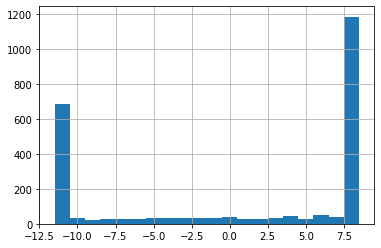

In [17]:
# show a histogram of those p&l's
log = dashapp.logging.getLogger(__name__)
log.setLevel(dashapp.logging.INFO)
display.display(df_es99['nday'].hist(bins=20))
iplot(dashapp.plotly_plot(
    df_in=df_es99[['settle_date','cum_nday','nday_dd','close_dd','close']],
    x_column='settle_date',yaxis2_cols=['nday_dd','close_dd'],y_left_label='cum_nday',
    y_right_label='close',plot_title='Cumulative Short Put Spread P&L vs Buy and Hold'
))

y_defs = [
    ['name','x_column','row','col','is_secondary','yaxis_title'],
    ['close','settle_date',1,1,False,'close'],
    ['cum_nday','settle_date',1,1,True, 'cum_nday'],
    ['close_dd','settle_date',2,1,False,'drawdown'],
    ['nday_dd','settle_date',2,1,False, 'drawdown']
]
df_fig = pd.DataFrame(y_defs[1:],columns=y_defs[0])
subtitles = ['Strategy Values vs Time','Drawdowns vs Time']
df_sub = df_es99[['settle_date','cum_nday','nday_dd','close_dd','close']]
sfig = dashapp.plotly_subplots(df_sub,df_fig,subplot_titles=subtitles)
sfig = go.Figure(sfig)
sfig.update_layout(
    legend=dict(x=0.1, y=1.2,orientation='h'),
    modebar={'orientation': 'v','bgcolor':'grey'}
)


In [18]:
# show the count and mean of positive and negative "n" day P&L's
allmean = df_es99['nday'].mean()
allcount = df_es99['nday'].count()
allsum = df_es99['nday'].sum()

upmean = df_es99[df_es99['nday']>0]['nday'].mean()
upcount = df_es99[df_es99['nday']>0]['nday'].count()
upsum = df_es99[df_es99['nday']>0]['nday'].sum()
upprob = upcount/allcount

downmean = df_es99[df_es99['nday']<0]['nday'].mean()
downcount = df_es99[df_es99['nday']<0]['nday'].count()
downsum = df_es99[df_es99['nday']<0]['nday'].sum()

evenmean = evensum = 0
evencount = df_es99[df_es99['nday']==0]['nday'].count()

pd.DataFrame({'direction':['all','up','down','even'],
              'count':[allcount,upcount,downcount,evencount],
              'mean':[allmean,upmean,downmean,evenmean],
              'sum':[allsum,upsum,downsum,evensum],
             'prob':[1,upprob,1-upprob,0]})
# df_es99[df_es99['nday']>0]['nday'].mean(),df_es99[df_es99['nday']<0]['nday'].mean()

direction  count      mean       sum      prob
0       all   2459  0.666381   1638.63  1.000000
1        up   1452  7.652424  11111.32  0.590484
2      down   1007 -9.406842  -9472.69  0.409516
3      even      0  0.000000      0.00  0.000000

In [19]:
avg_profit = upmean*upprob + downmean * (1-upprob)
total_profit = avg_profit * allcount
avg_profit, total_profit

(0.6663806425376144, 1638.629999999994)

In [20]:
df_test = df_es99.copy()
df_test['drawdown'] = get_draw_downs(df_test)
df_test2 = df_test[['settle_date','close','drawdown']]
iplot(dashapp.plotly_plot(df_test2,x_column='settle_date',yaxis2_cols=['drawdown']))


Text(0.5, 1.0, 'First estimate')

2020-06-20 14:23:47,232 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2020-06-20 14:23:47,233 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2020-06-20 14:23:47,235 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
2020-06-20 14:23:47,236 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,238 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2020-06-20 14:23:47,239 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-06-20 14:23:47,240 - matplotlib.font_manager - DEBUG - 

2020-06-20 14:23:47,340 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,342 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,343 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Estrangelo Talada' (SyrCOMTalada.otf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,344 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal black normal>) = 10.525
2020-06-20 14:23:47,345 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,346 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) normal normal regular normal>) = 10.05
2020-06-20 14:23:47,347 - matplotlib.font_manager - DEBUG 

2020-06-20 14:23:47,400 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05
2020-06-20 14:23:47,401 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335
2020-06-20 14:23:47,402 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Bitstream Vera Serif' (VeraSe.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,403 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,404 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,405 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal bold normal>) = 10.335
2020-06-20 14:23:47,406 - matplotlib.font_manager - DE

2020-06-20 14:23:47,454 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Estrangelo Midyat' (SyrCOMMidyat.otf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,455 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal bold normal>) = 6.698636363636363
2020-06-20 14:23:47,456 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,456 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,458 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
2020-06-20 14:23:47,459 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal bold normal>) = 4.971363636363637
2020-06-20 14:23:47,460 - matplotlib.font_manager - DEBU

2020-06-20 14:23:47,534 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Mishafi' (Mishafi.ttf) normal normal regular normal>) = 10.05
2020-06-20 14:23:47,535 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,535 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Bitstream Vera Sans' (VeraIt.ttf) oblique normal 400 normal>) = 1.9590909090909092
2020-06-20 14:23:47,536 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05
2020-06-20 14:23:47,537 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Medium.otf) normal normal medium normal>) = 10.145
2020-06-20 14:23:47,538 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Heavy.otf) normal normal heavy normal>) = 10.43
2020-06-20 14:23:47,539 - matplotlib.font_manager - DEBUG - fi

2020-06-20 14:23:47,604 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Silom' (Silom.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,605 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,606 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,607 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Goha-Tibeb Zemen' (GohaTibebZemen.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,608 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Athelas' (Athelas.ttc) normal normal regular normal>) = 10.05
2020-06-20 14:23:47,610 - matplotlib.font_manager - DEBUG - findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Semibold.otf) normal normal semibold normal>) = 10.24
2020-06-20 14:23:47,612 - matplotlib.font_manager - DEBUG - findfont: score(

2020-06-20 14:23:47,686 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal regular normal>) = 10.05
2020-06-20 14:23:47,687 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Sana' (Sana.ttc) normal normal regular normal>) = 10.05
2020-06-20 14:23:47,688 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 7.413636363636363
2020-06-20 14:23:47,690 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,692 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,693 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Raanana' (Raanana.ttc) normal normal 400 normal>) = 10.05
2020-06-20 14:23:47,694 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (ST

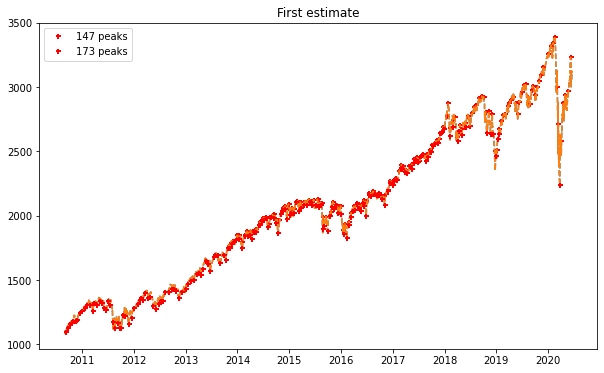

In [21]:
df_test = df_es99.copy()
df_test['date'] = [str_to_date(d,sep='') for d in df_es99.settle_date]
x = df_test.date.values

# get Peaks
y = df_test.high.values
high_indexes = peakutils.indexes(y, thres=0.3, min_dist=7)
# print(high_indexes)
# print(x[high_indexes], y[high_indexes])
plt.figure(figsize=(10,6))

# get Valleys
y = df_test.low.values * -1
low_indexes = peakutils.indexes(y, thres=0.3, min_dist=7)
# print(low_indexes)
y = df_test.close
pplot(x, y, high_indexes)
pplot(x, y, low_indexes)

plt.title('First estimate')
# for sn in dict_df2.keys():
#     df_test = dict_df2[sn]
#     for i in low_indexes:
#         try:
#             f = pu.plotly_candles(df=df_test.iloc[i-3:i+3],number_of_ticks_display=6,title=f'{sn} - {df_test.date.values[i]}')
#         except Exception as e:
#             print(f'{sn} error - {str(e)}')
# print(x[low_indexes])


## END

### Show corn vs crude correlations

In [22]:
sql = f"select settle_date, close  corn from {futtab} where symbol = 'ZCZ99'"
df_corn = pga.get_sql(sql)
sql = f"select settle_date, close  crude from {futtab} where symbol = 'CLZ99'"
df_crude = pga.get_sql(sql)

In [23]:
df_cc = df_crude.merge(df_corn,how='inner',on='settle_date')
df_cc['crude_ret'] = df_cc.crude.pct_change(1)
df_cc['corn_ret'] = df_cc.corn.pct_change(1)

display.display(df_cc.iloc[-50:][['crude','corn']].corr())
display.display(df_cc.iloc[-50:][['crude_ret','corn_ret']].corr())


crude      corn
crude  1.000000  0.538356
corn   0.538356  1.000000

crude_ret  corn_ret
crude_ret    1.00000   0.38341
corn_ret     0.38341   1.00000

In [24]:
df_cc['rolling_ret_cor'] = df_cc.crude_ret.rolling(40).corr(df_cc.corn_ret)
iplot(dashapp.plotly_plot(df_in=df_cc[['settle_date','rolling_ret_cor']].iloc[40:],
                         x_column='settle_date',
                          plot_title="Rolling 40 Trading Day Returns Correlation ",
                         y_left_label='Correlation'))

In [25]:
def get_this_monday_dt():
    dt_now = datetime.datetime.now()
    dt_monday= dt_now - datetime.timedelta(dt_now.weekday())
    return dt_monday

def get_this_monday_yyyymmdd():
    dt_monday= get_this_monday_dt()
    yyyymmdd = int(dt_monday.year)*100*100 + int(dt_monday.month)*100 + int(dt_monday.day)
    return yyyymmdd

fn = f'cme.settle.{get_this_monday_yyyymmdd()}.s.csv'
cmeurl = f'ftp://ftp.cmegroup.com/settle/{fn}'


In [26]:
df_cme = pd.read_csv(cmeurl)
df_cme.tail()

BizDt  Sym   ID  StrkPx SecTyp     MMY       MatDt  PutCall Exch  \
111901  2020-06-15  0BP  0BP     NaN    FUT  202008  2020-08-17      NaN  CME   
111902  2020-06-15  0BP  0BP     NaN    FUT  202009  2020-09-14      NaN  CME   
111903  2020-06-15  0BP  0BP     NaN    FUT  202010  2020-10-19      NaN  CME   
111904  2020-06-15  0BP  0BP     NaN    FUT  202012  2020-12-14      NaN  CME   
111905  2020-06-15  0BP  0BP     NaN    FUT  202103  2021-03-15      NaN  CME   

        Desc  ... HighBid  LowBid  PrevDayVol  PrevDayOI  FixingPrice  \
111901   NaN  ...     NaN     NaN           0          0          NaN   
111902   NaN  ...     NaN     NaN           0          0          NaN   
111903   NaN  ...     NaN     NaN           0          0          NaN   
111904   NaN  ...     NaN     NaN           0          0          NaN   
111905   NaN  ...     NaN     NaN           0          0          NaN   

        UndlyExch  UndlyID  UndlySecTyp  UndlyMMY  BankBusDay  
111901        NaN      NaN          NaN       NaN         NaN  
111902        NaN      NaN          NaN       NaN         NaN  
111903        NaN      NaN          NaN       NaN         NaN  
111904        NaN      NaN          NaN       NaN         NaN  
111905        NaN      NaN          NaN       NaN         NaN  

[5 rows x 29 columns]

In [27]:
def download_cme_ftp(yyyymmdd,
                     dest_directory = f"{str(pathlib.Path.home())}/downloads",
                    fn_base = 'cme.settle',do_ftp=True,):
    fn = f'{fn_base}.{yyyymmdd}.s.csv'
    cmeurl = f'ftp://ftp.cmegroup.com/settle/{fn}'
    ftpurl = cmeurl+'.zip'
    cmezipfile = fn+'.zip'
    
    dest_zip_path = f"{dest_directory}/{cmezipfile}"
    if os.path.isfile(dest_zip_path):
        with zipfile.ZipFile(dest_zip_path, 'r') as zip_ref:
            zip_ref.extractall(dest_directory)
    else:
        with closing(request.urlopen(ftpurl)) as r:
            with open(dest_zip_path, 'wb') as f:
                shutil.copyfileobj(r, f)
#     if do_ftp:
#         with closing(request.urlopen(ftpurl)) as r:
#             with open(dest_zip_path, 'wb') as f:
#                 shutil.copyfileobj(r, f)
#         with zipfile.ZipFile(dest_zip_path, 'r') as zip_ref:
#             zip_ref.extractall(dest_directory)
    dest_csv_file = f"{dest_directory}/{fn}"
#     !ls {dest_zip_path}
    !ls {dest_csv_file}
    return pd.read_csv(dest_csv_file)

In [28]:
def fsd(d):
    '''
    find significant digits
    '''
    for i in range(10):
        d2 = d * 10**i
        d3 = d2 - int(d2)
        if d3 == 0:
            return i
    return -1

def round_to_int(num:float,num_to_round_to:float):
    sign_digits = fsd(num_to_round_to)
    n = num * 10**sign_digits
    int_to_round_to = num_to_round_to * 10**sign_digits
    i = int(round(n/int_to_round_to,0)) * int_to_round_to
    r = i / 10**sign_digits
    return r



In [29]:
[
    round_to_int(3183.2,5),round_to_int(3182.2,5),
    round_to_int(35.82,.5),round_to_int(35.72,.5)
]

[3185.0, 3180.0, 36.0, 35.5]

In [30]:
monday_dt = get_this_monday_yyyymmdd()
df_nymex = download_cme_ftp(monday_dt,do_ftp=True,fn_base='nymex.settle')
[v for v in df_nymex.Sym.unique() if 'LO' in v]

/Users/bperlman1/downloads/nymex.settle.20200615.s.csv


['LO', 'LO1', 'LO3', 'LO4']

In [31]:

monday_dt = get_this_monday_yyyymmdd()
df_cme = download_cme_ftp(monday_dt,do_ftp=False,fn_base='cme.settle')
[v for v in df_cme.Sym.unique() if len(re.findall('E[1-4].',v))>0]

/Users/bperlman1/downloads/cme.settle.20200615.s.csv


['E23', 'E24', 'E33', 'E34', 'E1A', 'E1C', 'E2C', 'E3A', 'E3C', 'E4A', 'E4C']

In [32]:
df_cme

BizDt  Sym   ID  StrkPx SecTyp     MMY       MatDt  PutCall Exch  \
0       2020-06-15   CB   CB     NaN    FUT  202006  2020-07-01      NaN  CME   
1       2020-06-15   CB   CB    22.0    OOF  202006  2020-07-01      1.0  CME   
2       2020-06-15   CB   CB    22.0    OOF  202006  2020-07-01      0.0  CME   
3       2020-06-15   CB   CB    24.0    OOF  202006  2020-07-01      1.0  CME   
4       2020-06-15   CB   CB    24.0    OOF  202006  2020-07-01      0.0  CME   
...            ...  ...  ...     ...    ...     ...         ...      ...  ...   
111901  2020-06-15  0BP  0BP     NaN    FUT  202008  2020-08-17      NaN  CME   
111902  2020-06-15  0BP  0BP     NaN    FUT  202009  2020-09-14      NaN  CME   
111903  2020-06-15  0BP  0BP     NaN    FUT  202010  2020-10-19      NaN  CME   
111904  2020-06-15  0BP  0BP     NaN    FUT  202012  2020-12-14      NaN  CME   
111905  2020-06-15  0BP  0BP     NaN    FUT  202103  2021-03-15      NaN  CME   

        Desc  ... HighBid  LowBid  PrevDayVol  PrevDayOI  FixingPrice  \
0        NaN  ...  176.35     NaN           2       1520          NaN   
1        NaN  ...     NaN     NaN           0          0          NaN   
2        NaN  ...     NaN     NaN           0          0          NaN   
3        NaN  ...     NaN     NaN           0          0          NaN   
4        NaN  ...     NaN     NaN           0          0          NaN   
...      ...  ...     ...     ...         ...        ...          ...   
111901   NaN  ...     NaN     NaN           0          0          NaN   
111902   NaN  ...     NaN     NaN           0          0          NaN   
111903   NaN  ...     NaN     NaN           0          0          NaN   
111904   NaN  ...     NaN     NaN           0          0          NaN   
111905   NaN  ...     NaN     NaN           0          0          NaN   

        UndlyExch  UndlyID  UndlySecTyp  UndlyMMY  BankBusDay  
0             NaN      NaN          NaN       NaN         NaN  
1             CME       CB          FUT  202006.0         NaN  
2             CME       CB          FUT  202006.0         NaN  
3             CME       CB          FUT  202006.0         NaN  
4             CME       CB          FUT  202006.0         NaN  
...           ...      ...          ...       ...         ...  
111901        NaN      NaN          NaN       NaN         NaN  
111902        NaN      NaN          NaN       NaN         NaN  
111903        NaN      NaN          NaN       NaN         NaN  
111904        NaN      NaN          NaN       NaN         NaN  
111905        NaN      NaN          NaN       NaN         NaN  

[111906 rows x 29 columns]

In [33]:
monday_dt = get_this_monday_dt()
dict_round={'ES':5,'CL':.5}

# ES
fn_base = 'cme.settle'
yyyymm = 202009
do_download = True
underlying_sym = 'ES'
sym = 'E4A'
num_strikes = 2
dt_dates = [monday_dt + datetime.timedelta(i) for i in range(5) ]
yyyymmdds = [int(d.year)*100*100 + int(d.month)*100 + int(d.day) for d in dt_dates]
cp = 'C'

# CRUDE
fn_base = 'nymex.settle'
yyyymm = 202008
do_download = True
underlying_sym = 'CL'
sym = 'LO4'
num_strikes = 1
dt_dates = [monday_dt + datetime.timedelta(i) for i in range(5) ]
yyyymmdds = [int(d.year)*100*100 + int(d.month)*100 + int(d.day) for d in dt_dates]
cp = 'C'

for d in yyyymmdds:
    cp_num = 1 if cp.lower()=='c' else 0
    try:
        df_cme = download_cme_ftp(d,do_ftp=do_download,fn_base=fn_base)
    except:
        print(f"no cme ftp for yyyymmdd {d}")
        continue
    df_esfut = df_cme[(df_cme.Sym==underlying_sym) & (df_cme.SecTyp=='FUT') & (df_cme.MMY==yyyymm)]
    ss = df_esfut.SettlePrice.values[0]
    rounding = dict_round[underlying_sym]
    cs = round_to_int(ss,rounding)
    
    strk= [cs-rounding*num_strikes,cs,cs+rounding*num_strikes]
    df_cme2 = df_cme[(df_cme.Sym==sym) & (df_cme.StrkPx.isin(strk)) & (df_cme.PutCall==cp_num)]
    df_cme2['futures'] = ss
    display.display(df_cme2[['BizDt','StrkPx','PutCall','SettlePrice','futures']])
    

/Users/bperlman1/downloads/nymex.settle.20200615.s.csv


BizDt  StrkPx  PutCall  SettlePrice  futures
19468  2020-06-15    37.0      1.0         1.88    37.43
19470  2020-06-15    37.5      1.0         1.59    37.43

/Users/bperlman1/downloads/nymex.settle.20200616.s.csv


BizDt  StrkPx  PutCall  SettlePrice  futures
19497  2020-06-16    38.0      1.0         1.96    38.65
19499  2020-06-16    38.5      1.0         1.66    38.65
19501  2020-06-16    39.0      1.0         1.39    38.65

/Users/bperlman1/downloads/nymex.settle.20200617.s.csv


BizDt  StrkPx  PutCall  SettlePrice  futures
19525  2020-06-17    37.5      1.0         1.83    38.21
19527  2020-06-17    38.0      1.0         1.53    38.21
19529  2020-06-17    38.5      1.0         1.26    38.21

/Users/bperlman1/downloads/nymex.settle.20200618.s.csv


BizDt  StrkPx  PutCall  SettlePrice  futures
19163  2020-06-18    38.5      1.0         1.60    39.05
19165  2020-06-18    39.0      1.0         1.30    39.05
19167  2020-06-18    39.5      1.0         1.04    39.05

/Users/bperlman1/downloads/nymex.settle.20200619.s.csv


BizDt  StrkPx  PutCall  SettlePrice  futures
19207  2020-06-19    39.5      1.0         1.37    39.83
19209  2020-06-19    40.0      1.0         1.10    39.83
19211  2020-06-19    40.5      1.0         0.87    39.83

In [34]:
commod='CLZ99'
df_99 = pga.get_sql(f"select * from {futtab} where symbol='{commod}'")
# calculate a rolling "n" day P&L
spread = .5
days = 5
# df_99['nday'] = df_99.close - df_99.shift(days).close 
df_99['nday'] =  df_99.shift(days).close - df_99.close
df_99['nday'] = [(min(abs(v),spread)*v/abs(v)) if v!=0 else 0 for v in df_99['nday']]
# df_99.nday = df_99.nday - .05
df_99.nday = df_99.nday + .05

df_99['oneday'] = df_99.close - df_99.shift(1).close

df_99['cum_nday'] = df_99.nday.cumsum()# + df_99.close.values[0]
df_99['nday_dd'] = get_draw_downs(df_99,close='cum_nday')
df_99['close_dd'] = get_draw_downs(df_99)
# calculate sharpe ratios of buy and hold, and then of going short the put spread
sharpes = [
    df_99.close.pct_change().mean()/df_99.close.pct_change().std()*256**.5,
    df_99.cum_nday.pct_change().mean()/df_99.cum_nday.pct_change().std()*256**.5,
    df_99.oneday.mean()/df_99.oneday.std()*256**.5,
    df_99.nday.mean()/df_99.nday.std()*256**.5
]
print(sharpes)

[-0.3484501500361683, 0.3533555917942207, -0.11122713705170939, 1.398059587291124]


In [35]:
df_99.nday.sum()

101.76000000000016

In [36]:
# show the count and mean of positive and negative "n" day P&L's
allmean = df_99['nday'].mean()
allcount = df_99['nday'].count()
allsum = df_99['nday'].sum()

upmean = df_99[df_99['nday']>0]['nday'].mean()
upcount = df_99[df_99['nday']>0]['nday'].count()
upsum = df_99[df_99['nday']>0]['nday'].sum()
upprob = upcount/allcount

downmean = df_99[df_99['nday']<0]['nday'].mean()
downcount = df_99[df_99['nday']<0]['nday'].count()
downsum = df_99[df_99['nday']<0]['nday'].sum()

evenmean = evensum = 0
evencount = df_99[df_99['nday']==0]['nday'].count()

pd.DataFrame({'direction':['all','up','down','even'],
              'count':[allcount,upcount,downcount,evencount],
              'mean':[allmean,upmean,downmean,evenmean],
              'sum':[allsum,upsum,downsum,evensum],
             'prob':[1,upprob,1-upprob,0]})
# df_99[df_99['nday']>0]['nday'].mean(),df_99[df_99['nday']<0]['nday'].mean()

direction  count      mean     sum     prob
0       all   2455  0.041450  101.76  1.00000
1        up   1222  0.506203  618.58  0.49776
2      down   1233 -0.419157 -516.82  0.50224
3      even      0  0.000000    0.00  0.00000

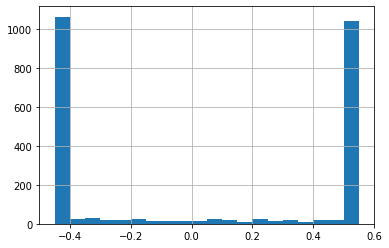

In [38]:
# show a histogram of those p&l's
log = dashapp.logging.getLogger(__name__)
log.setLevel(dashapp.logging.INFO)
display.display(df_99['nday'].hist(bins=20))
iplot(dashapp.plotly_plot(
    df_in=df_99[['settle_date','cum_nday','nday_dd','close_dd','close']],
    x_column='settle_date',yaxis2_cols=['nday_dd','close_dd'],y_left_label='cum_nday',
    y_right_label='close',plot_title='Cumulative Short Put Spread P&L vs Buy and Hold'
))

y_defs = [
    ['name','x_column','row','col','is_secondary','yaxis_title'],
    ['close','settle_date',1,1,False,'close'],
    ['cum_nday','settle_date',1,1,True, 'cum_nday'],
    ['close_dd','settle_date',2,1,False,'drawdown'],
    ['nday_dd','settle_date',2,1,False, 'drawdown']
]
df_fig = pd.DataFrame(y_defs[1:],columns=y_defs[0])
subtitles = ['Strategy Values vs Time','Drawdowns vs Time']
df_sub = df_99[['settle_date','cum_nday','nday_dd','close_dd','close']]
sfig = dashapp.plotly_subplots(df_sub,df_fig,subplot_titles=subtitles)
sfig = go.Figure(sfig)
sfig.update_layout(
    legend=dict(x=0.1, y=1.2,orientation='h'),
    modebar={'orientation': 'v','bgcolor':'grey'}
)

# plot_acf(df_99.nday.values[offset0:offset1],lags=20,title=t)


In [39]:
def fetch_history(symbol,yyyymmdd_beg,yyyymmdd_end):
    dt_beg = yyyymmdd_to_dt(yyyymmdd_beg)
    dt_end = yyyymmdd_to_dt(yyyymmdd_end)
    df = pdr.DataReader(symbol, 'yahoo', dt_beg, dt_end)
    # move index to date column, sort and recreate index
    df['date'] = df.index
    df = df.sort_values('date')
    df.index = list(range(len(df)))
    # make adj close the close
    df = df.drop(['Adj Close'],axis=1)
    cols = df.columns.values 
    cols_dict = {c:c[0].lower() + c[1:] for c in cols}
    df = df.rename(columns = cols_dict)
    df['settle_date'] = df.date.apply(str_to_yyyymmdd)
    return df


In [40]:
df_spy = fetch_history('SPY',19900103,20200612)
df_spy['pct_chg'] = df_spy.close.pct_change()
df_spy.pct_chg = df_spy.pct_chg.fillna(0)

2020-06-20 14:29:43,602 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): finance.yahoo.com:443
2020-06-20 14:29:44,335 - urllib3.connectionpool - DEBUG - https://finance.yahoo.com:443 "GET /quote/SPY/history?period1=631357200&period2=1592035199&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None


In [41]:
len(df_spy)

6893

In [42]:
import scipy
scipy.signal.correlate(df_spy.pct_chg.values[-100:-1],df_spy.pct_chg.values[1:])

array([ 1.44620937e-06,  6.77275356e-06, -1.73290458e-04, ...,
       -6.74253767e-04, -1.61824665e-04, -4.10020973e-04])

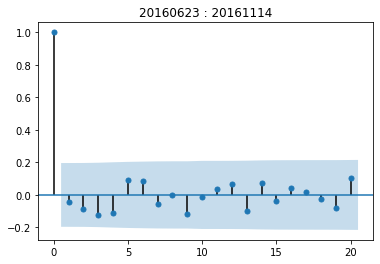

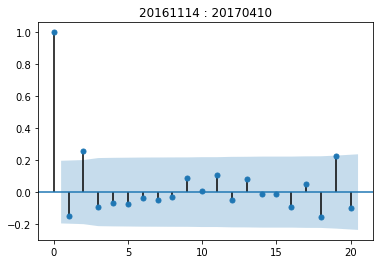

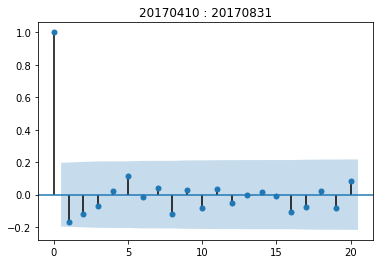

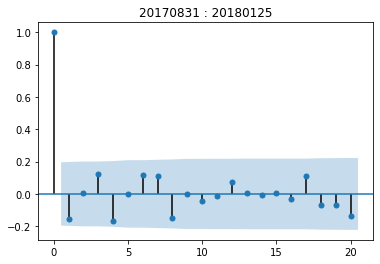

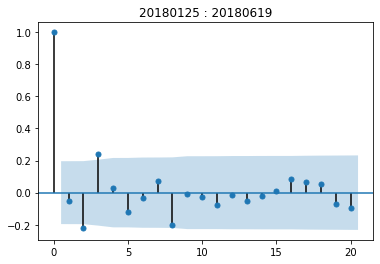

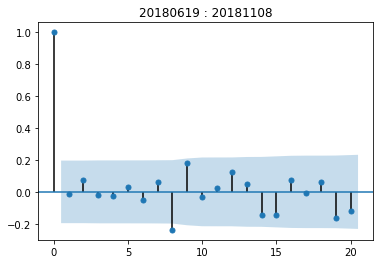

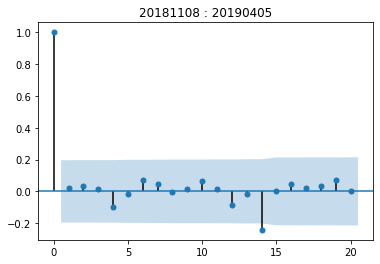

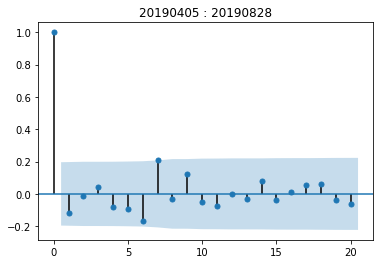

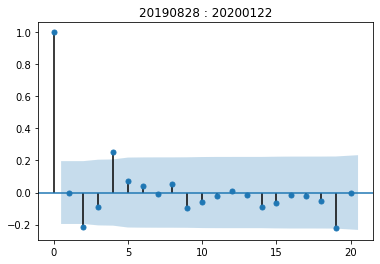

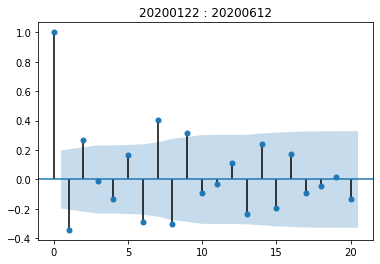

In [43]:
for i in range(10,0,-1):
    offset0 = -100*i
    offset1 = -100*(i-1) if i>1 else -1
    t = f"{df_spy.settle_date.values[offset0]} : {df_spy.settle_date.values[offset1]}"
        
    f=plot_acf(df_spy.pct_chg.values[offset0:offset1],lags=20,title=t)

In [44]:
corr_array_tuples = [
    (
        df_spy.settle_date[i+100],
        np.corrcoef(
            df_spy.pct_chg.values[i:i+99],
            df_spy.pct_chg.values[i+1:i+100])[0][1]
    ) for i in range(len(df_spy)-100)]
yyyymmdds = [t[0] for t in corr_array_tuples]
acfs = [t[1] for t in corr_array_tuples]
df_spy_acf = pd.DataFrame({'yyyymmdd':yyyymmdds,'acf':acfs})
iplot(dashapp.plotly_plot(df_in=df_spy_acf,x_column='yyyymmdd'))


In [45]:
df_99.columns.values

array(['symbol', 'settle_date', 'contract_num', 'open', 'high', 'low',
       'close', 'adj_close', 'volume', 'open_interest', 'nday', 'oneday',
       'cum_nday', 'nday_dd', 'close_dd'], dtype=object)

In [46]:
lags = 1
corr_days = 100
year = 2020
df_99_nona = df_99[~df_99.isna()]
corr_array_tuples = [
    (
        df_99_nona.settle_date[i+corr_days],
        np.corrcoef(
            df_99_nona.nday.values[i:i+corr_days-lags],
            df_99_nona.nday.values[i+lags:i+corr_days])[0][1]
    ) for i in range(len(df_99_nona)-corr_days)]
yyyymmdds = [t[0] for t in corr_array_tuples]
acfs = [t[1] for t in corr_array_tuples]
df_99_nona_acf = pd.DataFrame({'settle_date':yyyymmdds,'acf':acfs})
if year is not None:
    df_99_nona_acf = df_99_nona_acf[df_99_nona_acf.settle_date.astype(str).str.slice(0,4).astype(int)==year]
# df_99_nona_acf = df_99_nona_acf.merge(df_99[['settle_date','close','cum_nday']],on='settle_date',
#                                      how='inner')
# iplot(dashapp.plotly_plot(
#     df_in=df_99_nona_acf,x_column='settle_date',
#     yaxis2_cols=['close','cum_nday'],y_left_label='correlation',y_right_label='cum_nday'))

df_99_nona_acf = df_99_nona_acf.merge(df_99[['settle_date','cum_nday']],on='settle_date',
                                     how='inner')
iplot(dashapp.plotly_plot(
    df_in=df_99_nona_acf,x_column='settle_date',
    yaxis2_cols=['cum_nday'],y_left_label='correlation',y_right_label='cum_nday'))



In [47]:
lags = 1
corr_days = 100
year = None
df_99_nona = df_99[~df_99.isna()]
corr_array_tuples = [
    (
        df_99_nona.settle_date[i+corr_days],
        np.corrcoef(
            df_99_nona.nday.values[i:i+corr_days-lags],
            df_99_nona.nday.values[i+lags:i+corr_days])[0][1]
    ) for i in range(len(df_99_nona)-corr_days)]
yyyymmdds = [t[0] for t in corr_array_tuples]
acfs = [t[1] for t in corr_array_tuples]
df_99_nona_acf = pd.DataFrame({'settle_date':yyyymmdds,'acf':acfs})
if year is not None:
    df_99_nona_acf = df_99_nona_acf[df_99_nona_acf.settle_date.astype(str).str.slice(0,4).astype(int)==year]
# df_99_nona_acf = df_99_nona_acf.merge(df_99[['settle_date','close','cum_nday']],on='settle_date',
#                                      how='inner')
# iplot(dashapp.plotly_plot(
#     df_in=df_99_nona_acf,x_column='settle_date',
#     yaxis2_cols=['close','cum_nday'],y_left_label='correlation',y_right_label='cum_nday'))

df_99_nona_acf = df_99_nona_acf.merge(df_99[['settle_date','cum_nday']],on='settle_date',
                                     how='inner')
iplot(dashapp.plotly_plot(
    df_in=df_99_nona_acf,x_column='settle_date',
    yaxis2_cols=['cum_nday'],y_left_label='correlation',y_right_label='cum_nday'))



### create constant maturity futures contract

#### Show correlations

In [87]:
def get_commod_group(commods,beg_settle_date,end_settle_date):
    in_string = ','.join([f"'{c}'" for c in commods])
    sql = f"""
    select symbol,settle_date,close from {futtab} 
    where settle_date>={beg_settle_date}  and 
    settle_date<={end_settle_date} and 
    substring(symbol,1,{len(commods[0])}) in ({in_string})
    """
    df = pga.get_sql(sql)
    return df

In [96]:
def get_fut_contracts(commod,maturity,beg_settle_date,end_settle_date,pga):
    '''
    get a constant maturity futures contract for a specific commodity
    '''
    num_days = int(maturity+31*3) # add 2 months of contracts for 2nd order spline interpolation
    sql = f"""
    select symbol,settle_date,close from {futtab} 
    where settle_date>={beg_settle_date}  and 
    settle_date<={end_settle_date} and 
    substring(symbol,1,{len(commod)})='{commod}'
    """
    df = pga.get_sql(sql)
    settle_dates = sorted(df.settle_date.unique())
    constant_maturity_closes = []
    max_settle_dt = yyyymmdd_to_dt(max(settle_dates))
    max_expiry_date = max_settle_dt + datetime.timedelta(num_days)

    expiry_dates = {s:get_CL_expiry(s) for s in df.symbol.unique()}
    expiry_dates = {k:expiry_dates[k] for k in expiry_dates.keys() if expiry_dates[k]<=max_expiry_date}
    df = df[df.symbol.isin(expiry_dates.keys())]
    
    for settle_date in settle_dates:
        # get contracts for this settle_date
        df2 = df[['symbol','close']][df.settle_date==settle_date]
        settle_dt = yyyymmdd_to_dt(settle_date)
        df2['dte'] = [(get_expiry(s) - settle_dt).days for s in df2.symbol.values]
        df2 = df2[['dte','close']]
        df3 = pd.DataFrame({'dte':[maturity]})
        df3['close'] = np.nan
        df4 = df2.append(df3,ignore_index=True)
        df4 = df4.sort_values(['dte'])
        df4.index = df4.dte
        df4 = df4[['close']]
        # create interpolated iv's
        try:
            order = 2 if len(df2)>3 else 1
            df4['close'] = df4.close.interpolate(method='polynomial', order=order)
            cmc_value = df4[df4.index==maturity].close.values[0]
            if 'nan' in  str(cmc_value).lower():
                cmc_value = df4[df4.index>maturity].close.values[0]
            constant_maturity_closes.append(cmc_value)
        except Exception as e:
            ipdb.set_trace()
            constant_maturity_closes.append(None)
            print(e)
        
        
    return pd.DataFrame({'settle_date':settle_dates,'close':constant_maturity_closes})

In [93]:
commods = ['CL','HO','RB','ES']
yyyymmdd_beg = 20191220
yyyymmdd_end = 20200620
df_all_commods = get_commod_group(commods,yyyymmdd_beg,yyyymmdd_end)


In [97]:
maturity = 30
df_all_const = None
for commod in tqdm_notebook(commods):
#     df_commod = df_all_commods[df_all_commods.symbol.str.slice(0,len(commod))==commod]
    df_const = get_fut_contracts(commod,30,yyyymmdd_beg,yyyymmdd_end,pga)
#     df_const.close = df_const.close.pct_change()
    df_const.close = [0] + [np.log(v) for v in df_const.close.values[1:]/df_const.close.values[:-1]]
    df_const = df_const.rename(columns={'close':commod})
    df_const = df_const.iloc[1:]
    if df_all_const is None:
        df_all_const = df_const.copy()
    else:
        df_all_const = df_all_const.merge(df_const,on='settle_date',how='inner')
    
df_all_corr = df_all_const[commods].corr().round(3)
df_all_corr = pd.DataFrame(np.tril(df_all_corr.values),
                             index=df_all_corr.index,
                             columns=df_all_corr.columns)
df_all_corr = df_all_corr.iloc[1:][df_all_corr.columns.values[:-1]]
df_all_corr = df_all_corr.replace(1,0)
df_all_corr = df_all_corr.replace(0,'')
df_all_corr


CL     HO     RB
HO  0.784              
RB  0.670  0.674       
ES  0.284  0.423  0.636